# Plant Identification for Weed Control Project

## Libraries

In [1]:
import sys
import kagglehub
import warnings
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import piexif
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [2]:
# Install kagglehub and tifffile silently (no output shown)
subprocess.call([sys.executable, "-m", "pip", "install", "kagglehub", "tifffile"],
                stdout=open(os.devnull, "w"), stderr=subprocess.STDOUT)

0

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

# Download dataset locally
path = kagglehub.dataset_download("fpeccia/weed-detection-in-soybean-crops")
print("Path:", path)

Path: C:\Users\16302\.cache\kagglehub\datasets\fpeccia\weed-detection-in-soybean-crops\versions\1


## Data Preparation and Exploratory Data Analysis

           image_count
class                 
broadleaf         2150
grass             3520
soil              3249
soybean           7376


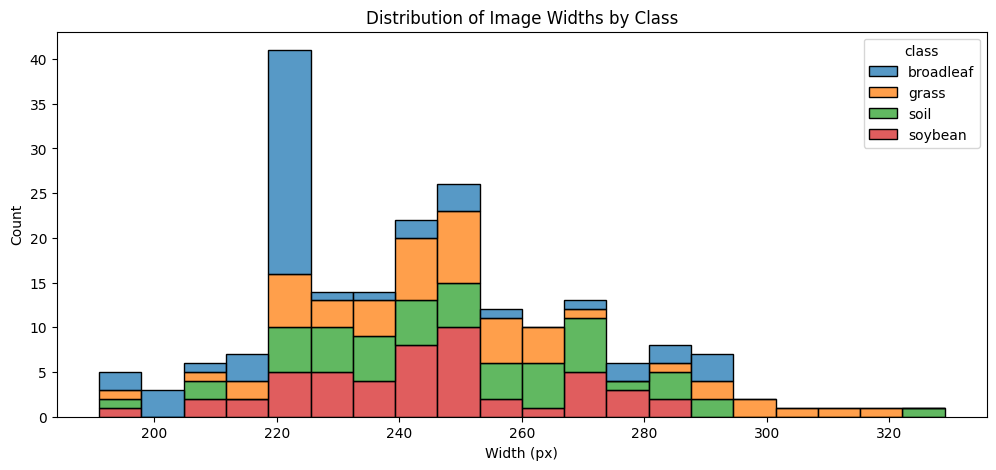

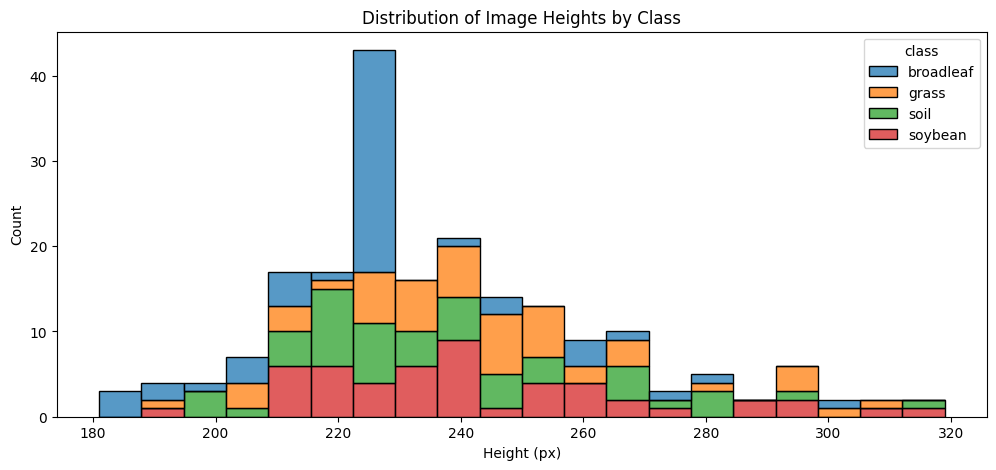

In [4]:
root = Path("C:/Users/16302/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1")
base = root / "dataset" / "dataset"
base_dir = base

# Define class labels from folder names
classes = sorted(p.name for p in base.iterdir() if p.is_dir())

# Resolution profiling: sample up to 50 images per class and record their sizes
records = []
for cls in classes:
    files = list((base/cls).iterdir())
    sample = random.sample(files, min(50, len(files)))
    for f in sample:
        img = Image.open(f)        
        width, height = img.size
        records.append({'class': cls, 'height': height, 'width': width})
df_shapes = pd.DataFrame(records)

# Univariate Non-Graphical EDA: count images per class
counts = {cls: len(list((base/cls).iterdir())) for cls in classes}
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['image_count'])
df_counts.index.name = 'class'
print(df_counts)

# Univariate Graphical EDA: Width, Height Distributions
plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='width', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Widths by Class")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='height', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Heights by Class")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

Summary Statistics (Height and Width by Class):
          height              width             
             min    mean  max   min    mean  max
class                                           
broadleaf    181  225.30  299   191  233.46  292
grass        192  243.64  306   195  249.72  317
soil         198  237.36  315   197  250.66  329
soybean      193  242.92  319   194  244.54  287


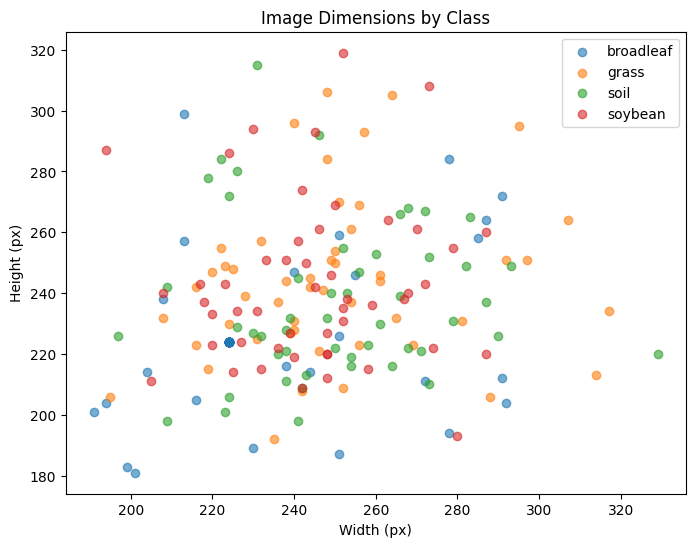

In [5]:
# Multivariate Non-Graphical Summary of Image Dimensions
summary_stats = df_shapes.groupby('class')[['height', 'width']].agg(['min', 'mean', 'max'])
print("Summary Statistics (Height and Width by Class):")
print(summary_stats)

# Multivariate Graphical Analysis - Scatter plot of sampled dimensions
plt.figure(figsize=(8,6))
for cls in classes:
    sub = df_shapes[df_shapes['class']==cls]
    plt.scatter(sub['width'], sub['height'], alpha=0.6, label=cls)
plt.xlabel("Width (px)"); plt.ylabel("Height (px)")
plt.title("Image Dimensions by Class"); plt.legend(); plt.show()

This dataset is imbalanced with soybean having 7,376 samples, while broadleaf, grass, and soil have 1,191, 3,520, and 3,249 images respectively. This will need to be corrected with class weighting or another method. 

Additionally, we have sampled the image dimensions by class and the dimensions range from 158 x 184 px to 404 x 324 px. This may need to be resized to a uniform input size such as 224 x 224 px, for example. 

#### Train Validation Split, Augmentation and class weighting to help with class imbalance


In [6]:
# Image processing config to resize for model input consistency
target_size = (224, 224)
batch_size = 32

In [7]:
# Handle broadleaf class imbalance by generating additional augmented images
# Uses aggressive augmentation to artificially increase the number of training samples for this under-represented class
# This creates synthesized variations of existing images by applying image transformations

# Directory where original broadleaf images are located
broadleaf_dir = os.path.join(base_dir, 'broadleaf')

# Directory to save augmented images (same class folder)
augmented_dir = broadleaf_dir

# Clean up old augmented images
for fname in os.listdir(broadleaf_dir):
    if fname.startswith('aug_broadleaf') and fname.endswith('.jpg'):
        os.remove(os.path.join(broadleaf_dir, fname))
print("Old augmented broadleaf images removed.")

# Create an ImageDataGenerator with aggressive augmentation
# Expose the model to broader intra-class variation
augment_broadleaf = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    shear_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Choose how many new images you want to generate (e.g., 500 more)
num_augmented = 1500
image_files = os.listdir(broadleaf_dir)
save_prefix = 'aug_broadleaf'

count = 0
for image_name in image_files:
    img_path = os.path.join(broadleaf_dir, image_name)
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in augment_broadleaf.flow(x, batch_size=1, save_to_dir=augmented_dir,
                                        save_prefix=save_prefix, save_format='jpg'):
        i += 1
        count += 1
        if i >= 1:
            break
        if count >= num_augmented:
            break
    if count >= num_augmented:
        break

print(f"Generated {count} new augmented broadleaf images.")

Old augmented broadleaf images removed.
Generated 1191 new augmented broadleaf images.


In [8]:
# ImageDataGenerator: Handles image preprocessing and augmentation across the classes, including brightness sensitivty
# This configuration is applied to both training and validation datasets (with validation_split)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Training generator: Loads training images with augmentations applied
train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator: Loads validation images (no augmentation, just rescaling)
val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 13169 images belonging to 4 classes.
Found 3291 images belonging to 4 classes.


The first number is the training set (80%).
The second number is the validation set (20%).

In [9]:
# Get the class labels for each image in the training set
labels = train_gen.classes

# Get mapping from class names to integer indices
class_indices = train_gen.class_indices

# Reverse the mapping to get index → class name
index_to_class = {v: k for k, v in class_indices.items()}

# Compute balanced class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Map weights to class index
class_weights = dict(zip(np.unique(labels), weights))

# Get mapping from index to class name
index_to_class = {v: k for k, v in train_gen.class_indices.items()}

# Manually boost broadleaf weight
for idx, name in index_to_class.items():
    if name == "broadleaf":
        class_weights[idx] *= 1.25  # boost by 25%

# Print updated weights
print("Updated class weights:")
for idx, weight in class_weights.items():
    class_name = index_to_class[idx]
    print(f"Index {idx}: {class_name:<10} → Weight: {weight:.3f}")

Updated class weights:
Index 0: broadleaf  → Weight: 2.222
Index 1: grass      → Weight: 1.169
Index 2: soil       → Weight: 1.266
Index 3: soybean    → Weight: 0.558


## Data Privacy 

Agricultural data does not contain personal identifying patient data or protected health info and data is not from a covered entity (such as hospital, clinical, financial institution); therefore HIPAA or personal protected data is not a concern.

However, one potential privacy risk lies in the geolocation metadata (EXIF data) embedded in image files, which may reveal where the image was captured. To address this, we include a verification and cleaning step to detect and remove any such metadata from .tif images.

In [10]:
# Track whether any metadata was found
found_metadata = False

# Iterate through all .tif files recursively
for img_path in base_dir.rglob("*.tif"):
    try:
        img = Image.open(img_path)
        if "exif" in img.info:
            print(f"Yes metadata: {img_path.name}")
            found_metadata = True
            # Strip metadata by saving a clean copy
            img_no_meta = Image.new(img.mode, img.size)
            img_no_meta.putdata(list(img.getdata()))
            img_no_meta.save(img_path)
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

# If no metadata was found in any file
if not found_metadata:
    print("No .tif images with metadata found.")

No .tif images with metadata found.


### CNN (Convolutional Neural Network)

In [11]:
# Define CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Train the model with class weights  
#history = cnn_model.fit(
 #   train_gen,
 #   validation_data=val_gen,
  #  epochs=8,
#    class_weight=class_weights
#)

Epoch 1/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.6205 - loss: 0.9344 - val_accuracy: 0.8551 - val_loss: 0.4004
Epoch 2/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8519 - loss: 0.4305 - val_accuracy: 0.8687 - val_loss: 0.3562
Epoch 3/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8726 - loss: 0.3703 - val_accuracy: 0.8739 - val_loss: 0.3238
Epoch 4/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8968 - loss: 0.3123 - val_accuracy: 0.9101 - val_loss: 0.2235
Epoch 5/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9112 - loss: 0.2669 - val_accuracy: 0.8988 - val_loss: 0.2531
Epoch 6/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9149 - loss: 0.2588 - val_accuracy: 0.9262 - val_loss: 0.1868
Epoch 7/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9251 - loss: 0.2406 - val_accuracy: 0.9222 - val_loss: 0.1902
Epoch 8/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9304 - loss: 0.2135 - val_accuracy: 0.

#### History Log Results of Training Model when first executed

Epoch 1/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.6205 - loss: 0.9344 - val_accuracy: 0.8551 - val_loss: 0.4004

Epoch 2/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8519 - loss: 0.4305 - val_accuracy: 0.8687 - val_loss: 0.3562

Epoch 3/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8726 - loss: 0.3703 - val_accuracy: 0.8739 - val_loss: 0.3238

Epoch 4/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8968 - loss: 0.3123 - val_accuracy: 0.9101 - val_loss: 0.2235

Epoch 5/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9112 - loss: 0.2669 - val_accuracy: 0.8988 - val_loss: 0.2531

Epoch 6/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9149 - loss: 0.2588 - val_accuracy: 0.9262 - val_loss: 0.1868

Epoch 7/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9251 - loss: 0.2406 - val_accuracy: 0.9222 - val_loss: 0.1902

Epoch 8/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9304 - loss: 0.2135 - val_accuracy: 0.9371 - val_loss: 0.1703

In [13]:
# Save the trained CNN model
cnn_model.save("cnn_model_epoch8.keras")
print("CNN model saved successfully.")

CNN model saved successfully.


### Load Pretrained Model
To avoid retraining after initial execution, download the pretrained model from Google Drive using the link below.
Save a copy to same local project folder as project notebook.

##### Link: [cnn_model_epoch8.keras](https://drive.google.com/file/d/1Wh0IRMk9Ch_nObGwF99CR7Zq7AqI2N3o/view?usp=sharing)


In [ ]:
# Automatically download the saved trained CNN model from Google Drive

# Check if model file exists
if not os.path.exists("cnn_model_epoch8.keras"):
    try:
        # Install gdown if needed
        import gdown
    except ImportError:
        !pip install gdown
        import gdown

    # Download using file ID
    file_id = "1Wh0IRMk9Ch_nObGwF99CR7Zq7AqI2N3o"
    gdown.download(id=file_id, output="cnn_model_epoch8.keras", quiet=False)

warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.saving.saving_lib')
# Load the model
cnn_model = load_model("cnn_model_epoch8.keras")
print("Model loaded successfully")


In [14]:
# History data of training model was retained since the model was saved for future loading to avoid training code re-execution
history_data = {
    'accuracy':     [0.6285, 0.8519, 0.8726, 0.8968, 0.9112, 0.9149, 0.9251, 0.9384],
    'val_accuracy': [0.8551, 0.8687, 0.8739, 0.9101, 0.8988, 0.9262, 0.9222, 0.9371],
    'loss':         [0.9344, 0.4305, 0.3703, 0.3123, 0.2669, 0.2588, 0.2406, 0.2135],
    'val_loss':     [0.4004, 0.3562, 0.3238, 0.2235, 0.2531, 0.1868, 0.1902, 0.1703]
}


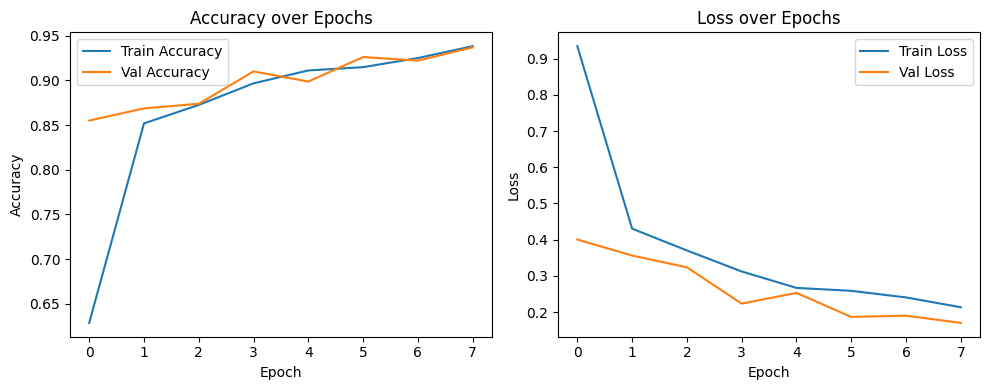

In [15]:
plt.figure(figsize=(10, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Plots show there is improvement in both training and validation accuracy and overall decrease in training and validation loss; this indicates model is learning effectively and generalizes well on unseen data with no signs of overfitting.


#### CNN Model Evaluation



In [16]:
# Evaluate trained CNN model on validation set

# Get true class labels and predicted labels
y_true_cnn = val_gen.classes
y_pred_cnn = cnn_model.predict(val_gen)  # Predict class probabilities for each validation image

# Get class predictions directly from argmax (no confidence threshold)
y_pred_labels_cnn = [np.argmax(probs) for probs in y_pred_cnn]

# Define expected labels and their target names
labels = [0, 1, 2, 3]
target_names = ["Broadleaf", "Grass", "Soil", "Soybean"]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_cnn, y_pred_labels_cnn, labels=labels, target_names=target_names))

103/103 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step
Classification Report:
              precision    recall  f1-score   support

   Broadleaf       0.80      0.86      0.83       463
       Grass       0.87      0.85      0.86       704
        Soil       1.00      1.00      1.00       649
     Soybean       0.98      0.96      0.97      1475

    accuracy                           0.93      3291
   macro avg       0.91      0.92      0.92      3291
weighted avg       0.93      0.93      0.93      3291



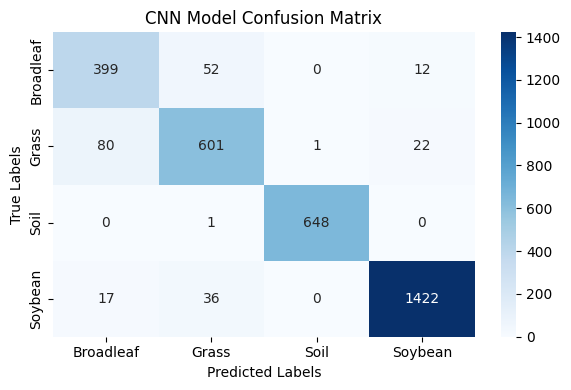

In [17]:
# Define all labels and their corresponding names
labels_all = [0, 1, 2, 3]
target_names = ["Broadleaf", "Grass", "Soil", "Soybean"]

# Compute confusion matrix with only valid labels
cnn_cm = confusion_matrix(y_true_cnn, y_pred_labels_cnn, labels=labels_all)

# Plot Confusion Matrix (cleaner version)
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("CNN Model Confusion Matrix")
plt.tight_layout()
plt.show()

Broadleaf is the most challenging class. Grass classifies mostly well with some confusion misclassifying as Broadleaf and Soybean. Soybean and Soil are the most confidentally predicted classes. Soybean is the best performing class.